Practical guide for how to download HuggingFaceTB/SmolLM2-135M and inspect its model architecture locally.


The SmolLM-135M is a compact, decoder-only transformer model designed for efficiency, with an architecture that prioritizes depth over width.

## Local Inference on GPU
Model page: https://huggingface.co/HuggingFaceTB/SmolLM2-135M

⚠️ If the generated code snippets do not work, please open an issue on either the [model repo](https://huggingface.co/HuggingFaceTB/SmolLM2-135M)
			and/or on [huggingface.js](https://github.com/huggingface/huggingface.js/blob/main/packages/tasks/src/model-libraries-snippets.ts) 🙏

## Load the Model (PyTorch)

In [198]:
# Load model directly
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-135M")
model = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM2-135M", dtype=torch.bfloat16)

## Load the Model (PyTorch)

SmolLM2 is a decoder-only transformer. Load it like:

In [199]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((576,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((576,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((576,), eps=1e-05)
    (rotary_emb): Lla

SmolLM2 borrows from LLaMA-style transformer architecture, including:
- Decoder-only transformer
- RMSNorm instead of LayerNorm
- Rotary positional embeddings (RoPE)
- SwiGLU / GELU-typical FFN architecture
- No biases in linear layers (LLaMA-style)
- Tied input/output embeddings

These design choices are typical in LLaMA-like models

## Architecture Summary of SmolLM2-135M

SmolLM2 is a small decoder-only transformer, similar to LLaMA-style architecture.

In [200]:
from transformers import AutoConfig

config = AutoConfig.from_pretrained("HuggingFaceTB/SmolLM2-135M")
config_dict = config.to_dict()
config_dict

{'vocab_size': 49152,
 'max_position_embeddings': 8192,
 'hidden_size': 576,
 'intermediate_size': 1536,
 'num_hidden_layers': 30,
 'num_attention_heads': 9,
 'num_key_value_heads': 3,
 'hidden_act': 'silu',
 'initializer_range': 0.041666666666666664,
 'rms_norm_eps': 1e-05,
 'pretraining_tp': 1,
 'use_cache': True,
 'rope_theta': 100000,
 'rope_scaling': None,
 'attention_bias': False,
 'attention_dropout': 0.0,
 'mlp_bias': False,
 'head_dim': 64,
 'return_dict': True,
 'output_hidden_states': False,
 'torchscript': False,
 'dtype': 'bfloat16',
 'pruned_heads': {},
 'tie_word_embeddings': True,
 'chunk_size_feed_forward': 0,
 'is_encoder_decoder': False,
 'is_decoder': False,
 'cross_attention_hidden_size': None,
 'add_cross_attention': False,
 'tie_encoder_decoder': False,
 'architectures': ['LlamaForCausalLM'],
 'finetuning_task': None,
 'id2label': {0: 'LABEL_0', 1: 'LABEL_1'},
 'label2id': {'LABEL_0': 0, 'LABEL_1': 1},
 'task_specific_params': None,
 'problem_type': None,
 'token

In [201]:
vocab_size = config_dict['vocab_size']
dim = config_dict['hidden_size']
n_layers = config_dict['num_hidden_layers']
n_heads = config_dict['num_attention_heads']
n_kv_heads = config_dict['num_key_value_heads']
norm_eps=config_dict['rms_norm_eps']
rope_theta=config_dict['rope_theta']


# multiple_of = config["multiple_of"]
# ffn_dim_multiplier = config["ffn_dim_multiplier"]

## SmolLM2-135M vs GPT-2 (Architecture Comparison)

### Model Type
| **Feature**             | **SmolLM2-135M**                | **GPT-2**                                |
|--------------------------|---------------------------------|-------------------------------------------|
| **Architecture**         | LLaMA-style decoder            | GPT-style decoder                        |
| **Model class**          | `LlamaForCausalLM`             | `GPT2LMHeadModel`                        |
| **Norm type**            | RMSNorm                        | LayerNorm                                |
| **Positional encoding**  | RoPE (rotary embeddings)       | Learned absolute position embeddings     |
| **Attention**            | GQA (9Q / 3KV)                 | Multi-head attention (no KV groups)      |
| **FFN activation**       | SiLU / SwiGLU-style            | GeLU                                     |
| **Weight tying**         | Yes                            | Yes                                      |


### Parameter Size
| **Component**       | **SmolLM2-135M** | **GPT-2 Small (117M)** |
|----------------------|------------------|--------------------------|
| **Hidden size**      | 576              | 768                      |
| **Layers**           | 30               | 12                       |
| **Attention heads**  | 9                | 12                       |
| **KV heads**         | 3 (GQA)          | 12                       |
| **FFN size**         | 1536             | 3072                     |
| **Seq length**       | 2048             | 1024                     |
| **Vocabulary**       | 49k              | 50k (BPE)                |

## Print layer weights

In [202]:

# Access state dict
sd = model.state_dict()

# Print all keys in order
for k in sd.keys():
    print(k)

model.embed_tokens.weight
model.layers.0.self_attn.q_proj.weight
model.layers.0.self_attn.k_proj.weight
model.layers.0.self_attn.v_proj.weight
model.layers.0.self_attn.o_proj.weight
model.layers.0.mlp.gate_proj.weight
model.layers.0.mlp.up_proj.weight
model.layers.0.mlp.down_proj.weight
model.layers.0.input_layernorm.weight
model.layers.0.post_attention_layernorm.weight
model.layers.1.self_attn.q_proj.weight
model.layers.1.self_attn.k_proj.weight
model.layers.1.self_attn.v_proj.weight
model.layers.1.self_attn.o_proj.weight
model.layers.1.mlp.gate_proj.weight
model.layers.1.mlp.up_proj.weight
model.layers.1.mlp.down_proj.weight
model.layers.1.input_layernorm.weight
model.layers.1.post_attention_layernorm.weight
model.layers.2.self_attn.q_proj.weight
model.layers.2.self_attn.k_proj.weight
model.layers.2.self_attn.v_proj.weight
model.layers.2.self_attn.o_proj.weight
model.layers.2.mlp.gate_proj.weight
model.layers.2.mlp.up_proj.weight
model.layers.2.mlp.down_proj.weight
model.layers.2.inp

Now that we know the architecture of SmolLM2, lets now try to implement it using some text, end to end

## converting text to tokens


In [203]:
prompt = "the answer to the ultimate question of life, the universe, and everything is "
# prompt = "your future is create by what you do today not "
tokens = tokenizer.encode(prompt)
print(tokens)
tokens = torch.tensor(tokens)
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]
print(prompt_split_as_tokens)

[1195, 2988, 288, 260, 10122, 1962, 282, 1029, 28, 260, 6128, 28, 284, 3117, 314, 216]
['the', ' answer', ' to', ' the', ' ultimate', ' question', ' of', ' life', ',', ' the', ' universe', ',', ' and', ' everything', ' is', ' ']


## converting tokens to their embedding
 our [16x1] tokens are now [16x576], i.e. 16 embeddings (one for each token) of length 576

In [204]:
vocab_size = model.config.vocab_size
dim = model.config.hidden_size

# Get the HF embedding tensor (LLaMA-style equivalent of tok_embeddings.weight)
hf_embedding_weight = model.model.embed_tokens.weight

# Create your own embedding layer
embedding_layer = torch.nn.Embedding(vocab_size, dim, dtype=torch.bfloat16)

# Copy weights from the model
embedding_layer.weight.data.copy_(hf_embedding_weight)

# Example: tokenize some text
prompt = "the answer to the ultimate question of life, the universe, and everything is "
# prompt = "your future is create by what you do today not "
tokens = tokenizer.encode(prompt)
tokens = torch.tensor(tokens)

# Compute unnormalized token embeddings
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)

print(token_embeddings_unnormalized.shape)


torch.Size([16, 576])


## we then normalize the embedding using rms normalization
please, note after this step the shapes dont change, the values are just normalized
things to keep in mind, we need a norm_eps (from config) because we dont want to accidently set rms to 0 and divide by 0
here is the formula:

In [205]:
def rms_norm(tensor, norm_weights):
    return (tensor * torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + norm_eps)) * norm_weights

## building the first first layer of the transformer


### normalization
you will see me accessing layer.0 from the model dict (this is the first layer)
anyway, so after normalizing our shapes are still [16x576] same as embedding but normalized

In [206]:
# token_embeddings_unnormalized: [1, seq_len, dim]
norm_weight = model.model.layers[0].input_layernorm.weight  # [dim]

token_embeddings = rms_norm(token_embeddings_unnormalized, norm_weight)
print(token_embeddings.shape)


torch.Size([16, 576])


## attention implemented from scratch
let's load the attention heads of the first layer of the transformer

> when we load the query, key, value and output vectors from the model we notice the shapes to be [576x576], [192x576], [192x576], [576x576]

In [207]:
q = model.model.layers[0].self_attn.q_proj.weight      # shape: [dim, dim]
k = model.model.layers[0].self_attn.k_proj.weight      # shape: [dim, dim/3]
v = model.model.layers[0].self_attn.v_proj.weight      # shape: [dim, dim/3]
o = model.model.layers[0].self_attn.o_proj.weight
print(q.shape, k.shape, v.shape, o.shape)

torch.Size([576, 576]) torch.Size([192, 576]) torch.Size([192, 576]) torch.Size([576, 576])


SmolLM2 uses GQA = Grouped Query Attention:

- Q has 9 heads → 9 × 64 = 576 output dims
- K/V have 3 heads → 3 × 64 = 192 output dims

- Input Dimension --> hidden_size =  576
- Query projection (Q) -->

      num_heads = 9
      head_dim = 64
      Q_dim = 9 * 64 = 576

      Q weight shape = [Q_dim, hidden_size]
                      = [576, 576]

- Key projection (K) -->

      num_key_value_heads = 3
      head_dim = 64
      K_dim = 3 * 64 = 192

      K weight shape = [K_dim, hidden_size]
                     = [192, 576]

- Value projection (V) --> same as K

      V weight shape = [V_dim, hidden_size]
                     = [192, 576]

- Output projection (O) --> O_proj merges the 9 attention heads back into hidden size:

      output dim = hidden_size = 576
      input dim to o_proj = Q_dim = 576


      O weight shape = [hidden_size, hidden_size]
                      = [576, 576]

## unwrapping query
nex we will unwrap the queries from multiple attention heads, the resulting shape is [9x64x576]

here, 9 is the number of attention heads, 64 is the size of the query vector and 576 is the size of the token embedding

In [208]:
q_layer0 = model.model.layers[0].self_attn.q_proj.weight
head_dim = q_layer0.shape[0] // n_heads   # 576 // 9 = 64
q_layer0 = q_layer0.view(n_heads, head_dim, dim)
q_layer0.shape

torch.Size([9, 64, 576])

im going to implement the first head of the first layer
here i access the query weight matrix first head of the first layer, the size of this query weight matrix is [64x576]

In [209]:
q_layer0_head0 = q_layer0[0]
q_layer0_head0.shape

torch.Size([64, 576])

we now multiply the query weights with the token embedding (Wq), to recive a query for the token
here you can see the resulting shape is [16x64], this is because we have 16 tokens and for each token there is a 64 length query.

In [210]:
q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T)
q_per_token.shape

torch.Size([16, 64])

positioning encoding
we are now at a stage where we have a query vector for each token in our prompt, but if you think about it -- the indivitually query vector has no idea about the position in the prompt.

query: "the answer to the ultimate question of life, the universe, and everything is "

in our prompt we have used "the" three times, we need the query vectors of all 3 "the" tokens to have different query vectors (each of size [1x64]) based on their positions in the query. we perform these rotations using RoPE (rotory positional embedding).

In [211]:
q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
q_per_token_split_into_pairs.shape

torch.Size([16, 32, 2])

in the above step, we split the query vectors into pairs, we apply a rotational angle shift to each pair!

we now have a vector of size [16, 32, 2], this is the 64 length queries split into 32 pairs for each token in the prompt! each of those 32 pairs will be rotated by m*(theta) where m is the position of the token for which we are rotating the query!

using dot product of complex numbers to rotate a vector


In [212]:
zero_to_one_split_into_32_parts = torch.tensor(range(32))/32
zero_to_one_split_into_32_parts

tensor([0.0000, 0.0312, 0.0625, 0.0938, 0.1250, 0.1562, 0.1875, 0.2188, 0.2500,
        0.2812, 0.3125, 0.3438, 0.3750, 0.4062, 0.4375, 0.4688, 0.5000, 0.5312,
        0.5625, 0.5938, 0.6250, 0.6562, 0.6875, 0.7188, 0.7500, 0.7812, 0.8125,
        0.8438, 0.8750, 0.9062, 0.9375, 0.9688])

In [213]:
freqs = 1.0 / (rope_theta ** zero_to_one_split_into_32_parts)
freqs

tensor([1.0000e+00, 6.9783e-01, 4.8697e-01, 3.3982e-01, 2.3714e-01, 1.6548e-01,
        1.1548e-01, 8.0584e-02, 5.6234e-02, 3.9242e-02, 2.7384e-02, 1.9110e-02,
        1.3335e-02, 9.3057e-03, 6.4938e-03, 4.5316e-03, 3.1623e-03, 2.2067e-03,
        1.5399e-03, 1.0746e-03, 7.4989e-04, 5.2330e-04, 3.6517e-04, 2.5483e-04,
        1.7783e-04, 1.2409e-04, 8.6596e-05, 6.0430e-05, 4.2170e-05, 2.9427e-05,
        2.0535e-05, 1.4330e-05])

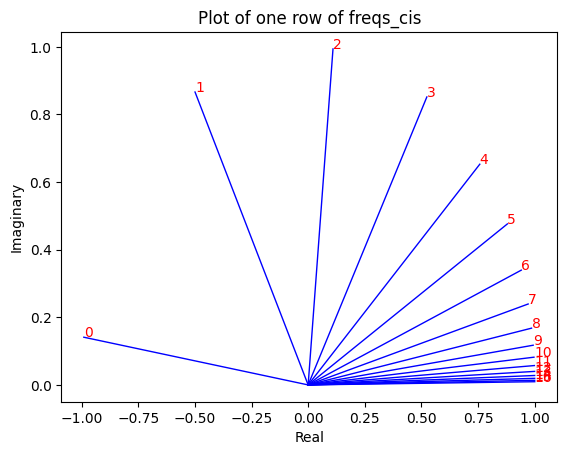

In [214]:
from matplotlib import pyplot as plt
freqs_for_each_token = torch.outer(torch.arange(16), freqs)
freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)
freqs_cis.shape

# viewing tjhe third row of freqs_cis
value = freqs_cis[3]
plt.figure()
for i, element in enumerate(value[:17]):
    plt.plot([0, element.real], [0, element.imag], color='blue', linewidth=1, label=f"Index: {i}")
    plt.annotate(f"{i}", xy=(element.real, element.imag), color='red')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Plot of one row of freqs_cis')
plt.show()

now that we have a complex number (the angle change vector) for every token's query element
we can convert our queries (the one we split into pairs) as complex numbers and then dot product to rotate the query based on the position
honeslty this is beautiful to think about :)

In [215]:
q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
q_per_token_as_complex_numbers.shape

torch.Size([16, 32])

In [216]:
q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis
q_per_token_as_complex_numbers_rotated.shape

torch.Size([16, 32])

after rotated vector is obtained
we can get back our the queries as pairs by viewing the complex numbers as real numbers again

In [217]:
q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated)
q_per_token_split_into_pairs_rotated.shape

torch.Size([16, 32, 2])

the rotated pairs are now merged, we now have a new query vector (rotated query vector) that is of the shape [16x64] where 16 is the number of tokens and the 64 is the dim of the query vector

In [218]:
q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
q_per_token_rotated.shape

torch.Size([16, 64])

## keys (almost the same as queries)

- keys generate key vectors also of dimention 64
- keys have only 1/3rd the number of the weights as queries, this is because the weights for keys are shared across 9 heads at a time, to reduce the number of computations need
- keys are also rotated to add positional info, just like queries because of the same reasons


In [219]:
k_layer0 = model.model.layers[0].self_attn.k_proj.weight
head_dim = k_layer0.shape[0] // n_kv_heads   # 576 // 9 = 64
k_layer0 = k_layer0.view(n_kv_heads, head_dim, dim)
k_layer0.shape

torch.Size([3, 64, 576])

In [220]:
k_layer0_head0 = k_layer0[0]
k_layer0_head0.shape

torch.Size([64, 576])

In [221]:
k_per_token = torch.matmul(token_embeddings, k_layer0_head0.T)
k_per_token.shape

torch.Size([16, 64])

In [222]:
k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
k_per_token_split_into_pairs.shape

torch.Size([16, 32, 2])

In [223]:
k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
k_per_token_as_complex_numbers.shape

torch.Size([16, 32])

In [224]:
k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
k_per_token_split_into_pairs_rotated.shape

torch.Size([16, 32, 2])

In [225]:
k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
k_per_token_rotated.shape

torch.Size([16, 64])

each of the queries and keys are now of shape [16x64].


## in the next step we will multiply the queries and key matrices

doing this will give us a score mapping each token with one another
this score describes how well each token's query relates to the each tokens's key. THIS IS SELF ATTENTION :)
the shape of the attention score matrix (qk_per_token) is [16x16] where 16 is the number of tokens in the prompt


In [226]:
qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5
qk_per_token.shape

torch.Size([16, 16])

## we now have to mask query key scores

during the training process, the future token qk scores are masked.
why? because during training we only learn to predict tokens using past tokens.
as a result, during inference we set the future tokens to zero.


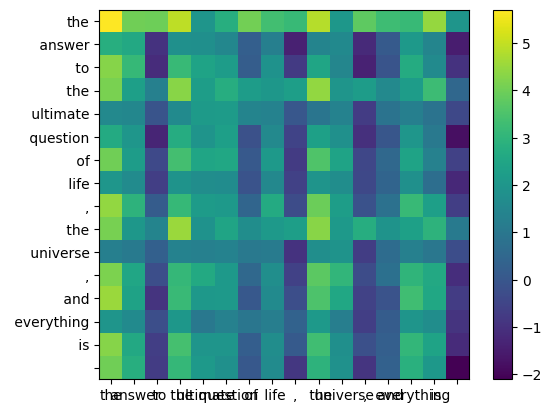

In [227]:
def display_qk_heatmap(qk_per_token):
    _, ax = plt.subplots()
    im = ax.imshow(qk_per_token.to(float).detach(), cmap='viridis')
    ax.set_xticks(range(len(prompt_split_as_tokens)))
    ax.set_yticks(range(len(prompt_split_as_tokens)))
    ax.set_xticklabels(prompt_split_as_tokens)
    ax.set_yticklabels(prompt_split_as_tokens)
    ax.figure.colorbar(im, ax=ax)

display_qk_heatmap(qk_per_token)

In [228]:
mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
mask = torch.triu(mask, diagonal=1)
mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

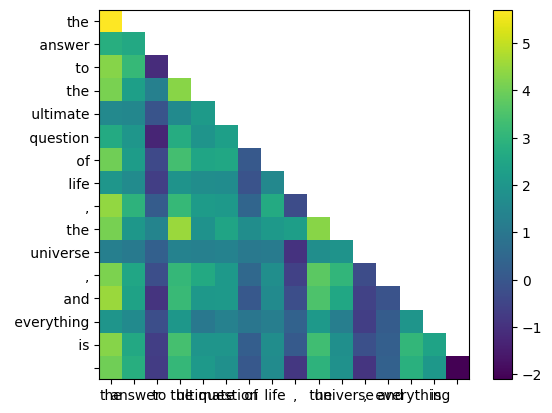

In [229]:
qk_per_token_after_masking = qk_per_token + mask
display_qk_heatmap(qk_per_token_after_masking)

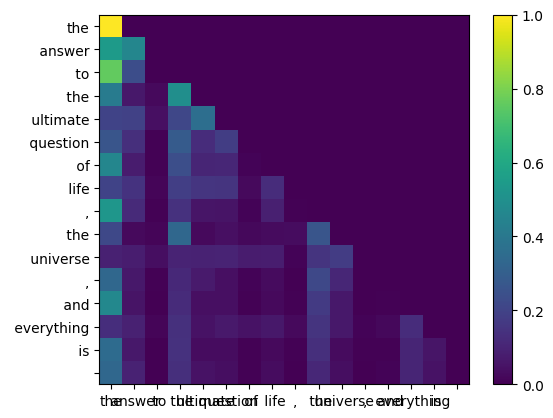

In [230]:
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
display_qk_heatmap(qk_per_token_after_masking_after_softmax)

## values (almost the end of attention)
these scores (0-1) are used to determine how much of value matrix is used per token
> just like keys, value weights are also shared acorss every 3 attention heads (to save computation)
> as a result, the shape of the value weight matrix below is [3x64x576]

In [231]:
v_layer0 = model.model.layers[0].self_attn.v_proj.weight
head_dim = v_layer0.shape[0] // n_kv_heads   # 576 // 9 = 64
v_layer0 = v_layer0.view(n_kv_heads, head_dim, dim)
v_layer0.shape

torch.Size([3, 64, 576])

In [232]:
v_layer0_head0 = v_layer0[0]
v_layer0_head0.shape

torch.Size([64, 576])

In [233]:
v_per_token = torch.matmul(token_embeddings, v_layer0_head0.T)
v_per_token.shape

torch.Size([16, 64])

In [234]:
qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
qkv_attention.shape

torch.Size([16, 64])

## multi head attention


In [235]:
qkv_attention_store = []

for head in range(n_heads):
    q_layer0_head = q_layer0[head]
    k_layer0_head = k_layer0[head//3] # key weights are shared across 4 heads
    v_layer0_head = v_layer0[head//3] # value weights are shared across 4 heads
    q_per_token = torch.matmul(token_embeddings, q_layer0_head.T)
    k_per_token = torch.matmul(token_embeddings, k_layer0_head.T)
    v_per_token = torch.matmul(token_embeddings, v_layer0_head.T)

    q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
    q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
    q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)

    k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
    k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
    k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)

    qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(64)**0.5
    mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
    mask = torch.triu(mask, diagonal=1)
    qk_per_token_after_masking = qk_per_token + mask
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention_store.append(qkv_attention)

len(qkv_attention_store)

9

merge all attention scores into one large matrix of size [16x576]

In [236]:
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
stacked_qkv_attention.shape

torch.Size([16, 576])

## weight matrix, one of the final steps


In [237]:
o_layer0 = model.model.layers[0].self_attn.o_proj.weight
o_layer0.shape

torch.Size([576, 576])

In [238]:
embedding_delta = torch.matmul(stacked_qkv_attention, o_layer0.T)
embedding_delta.shape

torch.Size([16, 576])

we now have the change in the embedding value after attention, that should be adding to the original token embeddings


In [239]:
embedding_after_edit = token_embeddings_unnormalized + embedding_delta
embedding_after_edit.shape

torch.Size([16, 576])

## we normalize and then run a feed forward neural network through the embedding delta

In [240]:
# model.embed_tokens.weight
# model.layers.0.self_attn.q_proj.weight
# model.layers.0.self_attn.k_proj.weight
# model.layers.0.self_attn.v_proj.weight
# model.layers.0.self_attn.o_proj.weight
# model.layers.0.mlp.gate_proj.weight
# model.layers.0.mlp.up_proj.weight
# model.layers.0.mlp.down_proj.weight
# model.layers.0.input_layernorm.weight
# model.layers.0.post_attention_layernorm.weight

In [241]:
embedding_after_edit_normalized = rms_norm(embedding_after_edit, model.model.layers[0].post_attention_layernorm.weight)
embedding_after_edit_normalized.shape

torch.Size([16, 576])

## loading the ff weights and implementing the feed forward network


In [242]:
# Extract weights
w1 = model.model.layers[0].mlp.gate_proj.weight  # gate
w2 = model.model.layers[0].mlp.up_proj.weight    # up
w3 = model.model.layers[0].mlp.down_proj.weight  # down

x = embedding_after_edit_normalized  # shape: [batch, hidden_dim]

# Gate and up projections
gate_out = torch.matmul(x, w1.T)  # [batch, intermediate_dim]
up_out = torch.matmul(x, w2.T)    # [batch, intermediate_dim]

# Apply SiLU on gate
activated_gate = torch.nn.functional.silu(gate_out)

# Element-wise product
gated_output = activated_gate * up_out  # [batch, intermediate_dim]

# Down projection
output_after_feedforward = torch.matmul(gated_output, w3.T)  # [batch, hidden_dim]

print(output_after_feedforward.shape)

torch.Size([16, 576])


In [243]:
w1 = model.model.layers[0].mlp.gate_proj.weight
w2 = model.model.layers[0].mlp.up_proj.weight
w3 = model.model.layers[0].mlp.down_proj.weight
output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w2.T), w3.T)
output_after_feedforward.shape

torch.Size([16, 576])

In [244]:
layer_0_embedding = embedding_after_edit+output_after_feedforward
layer_0_embedding.shape

torch.Size([16, 576])

In [245]:
# q = model.model.layers[0].self_attn.q_proj.weight      # shape: [dim, dim]
# k = model.model.layers[0].self_attn.k_proj.weight      # shape: [dim, dim/3]
# v = model.model.layers[0].self_attn.v_proj.weight      # shape: [dim, dim/3]
# o = model.model.layers[0].self_attn.o_proj.weight

In [254]:
n_layers,n_heads,head

(30, 9, 8)

In [246]:
final_embedding = token_embeddings_unnormalized
for layer in range(n_layers):
    qkv_attention_store = []
    layer_embedding_norm = rms_norm(final_embedding, model.model.layers[layer].input_layernorm.weight)
    q_layer = model.model.layers[layer].self_attn.q_proj.weight
    q_layer = q_layer.view(n_heads, q_layer.shape[0] // n_heads, dim)
    k_layer = model.model.layers[layer].self_attn.k_proj.weight
    k_layer = k_layer.view(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
    v_layer = model.model.layers[layer].self_attn.v_proj.weight
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)
    w_layer = model.model.layers[layer].self_attn.o_proj.weight
    for head in range(n_heads):
        q_layer_head = q_layer[head]
        k_layer_head = k_layer[head//3]
        v_layer_head = v_layer[head//3]
        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)
        q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
        q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
        q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis)
        q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
        k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
        k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
        k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
        k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(64)**0.5
        mask = torch.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))
        mask = torch.triu(mask, diagonal=1)
        qk_per_token_after_masking = qk_per_token + mask
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
        qkv_attention_store.append(qkv_attention)

    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
    w_layer = model.model.layers[layer].self_attn.o_proj.weight
    embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)
    embedding_after_edit = final_embedding + embedding_delta
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, model.model.layers[layer].post_attention_layernorm.weight)
    w1 = model.model.layers[layer].mlp.gate_proj.weight
    w2 = model.model.layers[layer].mlp.up_proj.weight
    w3 = model.model.layers[layer].mlp.down_proj.weight
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w2.T), w3.T)
    final_embedding = embedding_after_edit+output_after_feedforward


we now have the final embedding, the best guess the model could make about the next token

In [247]:
final_embedding = rms_norm(final_embedding, model.model.norm.weight)
final_embedding.shape

torch.Size([16, 576])

In [248]:
model.lm_head.weight.shape


torch.Size([49152, 576])

## we use the embedding of the last token to predict the next value

In [249]:
logits = torch.matmul(final_embedding[-1], model.lm_head.weight.T)
logits.shape

torch.Size([49152])

In [250]:
next_token = torch.argmax(logits, dim=-1)
next_token

tensor(198)

In [251]:
tokenizer.decode([next_token.item()])


'\n'